<a href="https://colab.research.google.com/github/omarja12/DS_Project3/blob/main/Project3_GroupD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3 - Clustering
## Insurance company customers' segmentation 
### This notebook uses the *a2z_insurance.sas7bdat* dataset

(c) Vasco Jesus, Nuno António 2020-2022 - Rev. 1.0

## Dataset description

- **CustID**: numeric - customer ID
- **FirstPolYear**: numeric - year of the customer's first policy. Maybe considered the first year as a customer
- **BirthYear**: numeric - birth year of the customer. The current year of the database is 2016
- **EducDeg**: categorical - academic degree
- **MonthSal**: numerical - monthly gross salary (€)
- **GeoLivArea**: numerical - codes about the area of living. No additional information is available for these codes
- **Children**: numerical - indication if the customer has children (0: no, 1: yes)
- **CustMonVal**: numerical - customer monetary value (CMV). CMV = (annual profit from the customer) x (number of years since a customer) - (acquisition cost)
- **ClaimsRate**: numerical - claims rate. Amount paid by the insurance company (€)/Premiums(€) (in the last two years)
- **PremMotor**: numerical - premiums in the Line of Business (LOB) Motor (€)
- **PremHousehold**: numerical - premiums in the LOB Household (€)
- **PremHealth**: numerical - premiums in the LOB Health (€)
- **PremLife**: numerical - premiums in the LOB Life (€)
- **PremWork**: numerical - premiums in the LOB Work (€)

<br>NOTES about all Premiums:
- Annual premiums (2016)
- Negative premiums may manifest reversals occurred in the current year, paid in previous one(s)

## Work description

### Overview
<p>You should organize into groups of 3 to 5 students, where you will assume the role of a consultant. You are asked to develop a Customer Segmentation in such a way that it will be possible for the Marketing Department of an insurance company to understand all the different Customers’ Profiles better.</p>
<p>Employing the CRISP-DM process model, you are expected to define, describe and explain the clusters you chose. Invest time in reasoning how you want to do your clustering, possible approaches, and advantages or disadvantages of different decisions. Simultaneous, you should express the marketing approach you recommend for each cluster.</p>

### Questions or additional informations
For any additional questions, don't hesitate to get in touch with the instructor. The instructor will also act as the insurance company business/project stakeholder.

## Initializations and data loading

In [149]:
!pip install category_encoders

     |████████████████████████████████| 86 kB 2.6 MB/s 


In [153]:
!pip install joypy

In [154]:
# Loading packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np




# Packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import joypy
import category_encoders as ce
import collections
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [96]:
import requests as rq
from io import BytesIO

url = "https://raw.githubusercontent.com/omarja12/DS_Project3/main/a2z_insurance.sas7bdat"

data = rq.get(url).content

# Loading the dataset
ds = pd.read_sas(BytesIO(data), format='sas7bdat')

In [97]:
#  Visualizing summary statistics

ds.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CustID,10296.0,NaN,NaN,NaN,5148.5,2972.34352,1.0,2574.75,5148.5,7722.25,10296.0
FirstPolYear,10266.0,NaN,NaN,NaN,1991.062634,511.267913,1974.0,1980.0,1986.0,1992.0,53784.0
BirthYear,10279.0,NaN,NaN,NaN,1968.007783,19.709476,1028.0,1953.0,1968.0,1983.0,2001.0
EducDeg,10279,4,b'3 - BSc/MSc',4799,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthSal,10260.0,NaN,NaN,NaN,2506.667057,1157.449634,333.0,1706.0,2501.5,3290.25,55215.0
GeoLivArea,10295.0,NaN,NaN,NaN,2.709859,1.266291,1.0,1.0,3.0,4.0,4.0
Children,10275.0,NaN,NaN,NaN,0.706764,0.455268,0.0,0.0,1.0,1.0,1.0
CustMonVal,10296.0,NaN,NaN,NaN,177.892605,1945.811505,-165680.42,-9.44,186.87,399.7775,11875.89
ClaimsRate,10296.0,NaN,NaN,NaN,0.742772,2.916964,0.0,0.39,0.72,0.98,256.2
PremMotor,10262.0,NaN,NaN,NaN,300.470252,211.914997,-4.11,190.59,298.61,408.3,11604.42


In [98]:
# Show top rows
ds.head()

,CustID,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
0,1.0,1985.0,1982.0,b'2 - High School',2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
1,2.0,1981.0,1995.0,b'2 - High School',677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
2,3.0,1991.0,1970.0,b'1 - Basic',2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
3,4.0,1990.0,1981.0,b'3 - BSc/MSc',1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
4,5.0,1986.0,1973.0,b'3 - BSc/MSc',1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45


# Data Exploration:

In [99]:
ds.duplicated().sum()

0

We can see that our dataset does not contain any duplicates.

In [100]:
ds.drop(columns=['CustID'], inplace=True)

Dropping the 'ID' column as it does not provide any informations.

In [101]:
ds.head(1)

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
0,1985.0,1982.0,b'2 - High School',2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89


### The variable 'FirstPolYear':

In [102]:
ds['FirstPolYear'].value_counts()

1988.0     512
1994.0     475
1993.0     473
1989.0     466
1984.0     464
1986.0     458
1977.0     453
1978.0     453
1992.0     451
1990.0     449
1981.0     445
1995.0     445
1982.0     444
1979.0     443
1996.0     440
1987.0     438
1976.0     433
1980.0     432
1991.0     430
1985.0     429
1983.0     423
1975.0     285
1997.0     271
1974.0     141
1998.0     112
53784.0      1
Name: FirstPolYear, dtype: int64

We need to drop the observations with values equal to 53784. 

In [103]:
ds = ds[~ds['FirstPolYear'].isin([53784.0, np.nan, 'nan'])]

### The variable 'BirthYear':

In [104]:
ds['BirthYear'].unique()

array([1982., 1995., 1970., 1981., 1973., 1956., 1943., 1974., 1978.,
       1948., 1945., 1958., 1949., 2000., 1975., 1979., 1989., 1962.,
       1986., 1961., 1952., 1944., 1937., 1942., 1972., 1953., 1966.,
       1955., 1941., 1938., 1968., 1990., 1984., 1980., 1946., 1965.,
       1957., 1967., 1977., 1951., 1985., 1959., 1988., 1983., 1939.,
       1964., 1950., 1960., 1976., 1971., 1954., 1969., 1994., 1992.,
       1997., 1963., 1991., 1999., 1993., 1947., 1987., 1996., 1940.,
       1935., 1936.,   nan, 1998., 2001., 1028.])

We need to drop the birth year equal to 1028, and the nan.

In [105]:
ds = ds[~ds['BirthYear'].isin([1028.0, np.nan])]

### The variable  'EducDeg':

In [106]:
ds['EducDeg'].value_counts()

b'3 - BSc/MSc'        4789
b'2 - High School'    3497
b'1 - Basic'          1268
b'4 - PhD'             694
Name: EducDeg, dtype: int64

Removing the b infront of the category name.

In [107]:
ds['EducDeg'] = ds['EducDeg'].astype(str)
ds['EducDeg'] = ds['EducDeg'].str.replace(r'b', '')

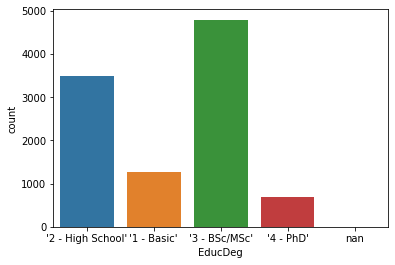

In [108]:
# Counting the genders in the dataset.

sns.countplot(data=ds, x="EducDeg")
plt.show()

We need to get rid of the nans.

In [109]:
ds = ds[~ds['EducDeg'].isin([np.nan, 'nan'])]

In [110]:
ds['EducDeg'].unique()

array(["'2 - High School'", "'1 - Basic'", "'3 - BSc/MSc'", "'4 - PhD'"],
      dtype=object)

### The variable 'MonthSal':

In [111]:
ds = ds[~ds['MonthSal'].isin([np.nan, 'nan'])]

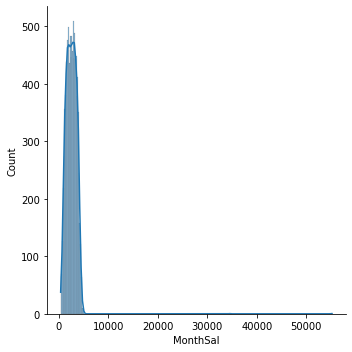

In [112]:
# Checking the histogram of the variable 'MonthSal'

sns.displot(data=ds, x="MonthSal", kde=True)
plt.show()

The figure above shows the presence of outliers values that are very far from the true distribution of salaries.

### The variable 'GeoLivArea':

In [113]:
ds['GeoLivArea'].unique()

array([1., 4., 3., 2.])

We need to remove the nans values.

In [114]:
ds = ds[~ds['GeoLivArea'].isin([np.nan, 'nan'])]

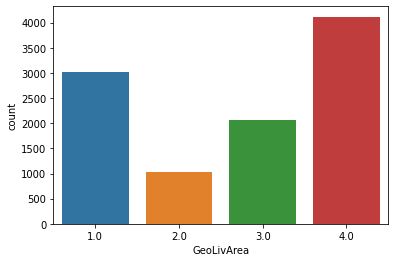

In [115]:
# Counting the 'GeoLivArea' in the dataset.

sns.countplot(data=ds, x="GeoLivArea")
plt.show()

### The variable 'Children':

In [116]:
ds['Children'].unique()

array([ 1.,  0., nan])

Again we need to get rid of the nans.

In [117]:
ds = ds[~ds['Children'].isin([np.nan, 'nan'])]

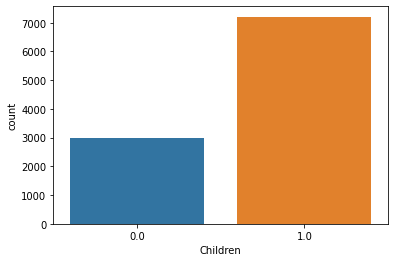

In [118]:
# Counting the 'Children' in the dataset.

sns.countplot(data=ds, x="Children")
plt.show()

We can see that most people in the dataset have children.

### The variable 'CustMonVal':

In [119]:
ds['CustMonVal'].unique()

array([ 380.97, -131.13,  504.67, ..., 1405.6 ,  524.1 ,  463.75])

In [120]:
ds = ds[~ds['CustMonVal'].isin([np.nan, 'nan'])]

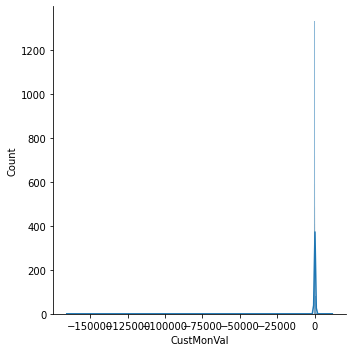

In [121]:
# Checking the histogram of the variable 'MonthSal'

sns.displot(data=ds, x="CustMonVal", kde=True)
plt.show()

We can see observations with very small negative values, they might be outliers we will decide how to deal with them in the next steps.

### The variable 'ClaimsRate':

In [122]:
ds['ClaimsRate'].unique()

array([3.900e-01, 1.120e+00, 2.800e-01, 9.900e-01, 9.000e-01, 1.000e+00,
       1.050e+00, 1.130e+00, 3.600e-01, 5.300e-01, 4.600e-01, 9.700e-01,
       1.060e+00, 8.900e-01, 8.500e-01, 7.100e-01, 1.080e+00, 6.400e-01,
       8.100e-01, 4.100e-01, 3.800e-01, 5.000e-01, 9.600e-01, 1.900e-01,
       6.900e-01, 4.800e-01, 9.400e-01, 1.010e+00, 9.800e-01, 8.400e-01,
       4.700e-01, 1.070e+00, 1.190e+00, 6.300e-01, 1.200e+00, 3.200e-01,
       2.536e+01, 1.140e+00, 5.900e-01, 1.300e-01, 6.600e-01, 6.800e-01,
       6.100e-01, 7.800e-01, 3.300e-01, 7.200e-01, 2.000e-01, 1.040e+00,
       4.200e-01, 9.500e-01, 3.500e-01, 1.030e+00, 1.210e+00, 4.000e-01,
       4.400e-01, 7.700e-01, 9.300e-01, 5.400e-01, 2.500e-01, 4.300e-01,
       1.565e+01, 4.900e-01, 1.400e-01, 6.200e-01, 5.600e-01, 5.700e-01,
       1.800e-01, 9.100e-01, 8.200e-01, 1.200e-01, 1.480e+01, 6.500e-01,
       3.100e-01, 9.000e-02, 2.200e-01, 6.000e-02, 3.000e-01, 5.100e-01,
       2.600e-01, 5.200e-01, 6.700e-01, 5.800e-01, 

This variable does not contains any nans.
We will plot its histogram.

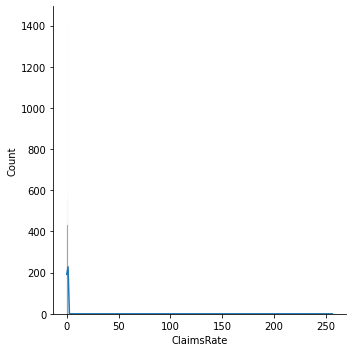

In [123]:
# Checking the histogram of the variable 'ClaimsRate'

sns.displot(data=ds, x="ClaimsRate", kde=True)
plt.show()

We can see that the variable contains some outliers with claims Rate above 250.

### The variable 'PremMotor':

In [124]:
ds['PremMotor'].unique()

array([375.85,  77.46, 206.15, ..., 105.13, 556.77,   6.89])

In [125]:
ds = ds[~ds['PremMotor'].isin([np.nan, 'nan'])]

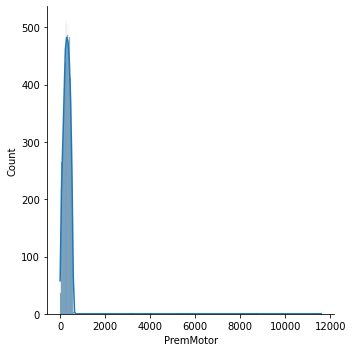

In [126]:
# Checking the histogram of the variable 'PremMotor'

sns.displot(data=ds, x="PremMotor", kde=True)
plt.show()

The variable seems to contains some outliers.

### The variable 'PremHousehold'

In [127]:
ds['PremHousehold'].unique()

array([  79.45,  416.2 ,  224.5 , ..., 1070.2 , 1045.75, 1035.75])

In [128]:
ds = ds[~ds['PremHousehold'].isin([np.nan, 'nan'])]

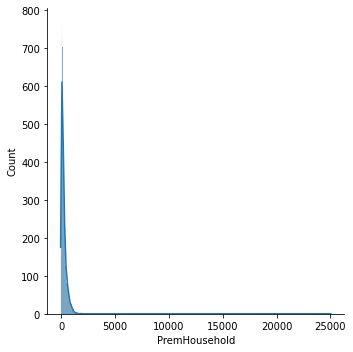

In [129]:
# Checking the histogram of the variable 'PremHousehold'

sns.displot(data=ds, x="PremHousehold", kde=True)
plt.show()

The distribution is right skewed as it contains very big Household premiums values.

### The variable 'Premhealth':

In [130]:
ds['PremHealth'].unique()

array([146.36, 116.69, 124.58, ..., 327.73, 390.74, 417.08])

In [131]:
ds = ds[~ds['PremHealth'].isin([np.nan, 'nan'])]

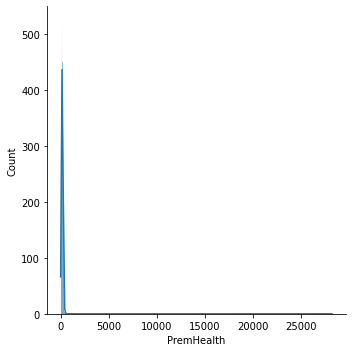

In [132]:
# Checking the histogram of the variable 'PremHealth'

sns.displot(data=ds, x="PremHealth", kde=True)
plt.show()

Right skewed distribution with very high values.

### The variable 'PremLife':

In [133]:
ds['PremLife'].unique()

array([ 4.7010e+01,  1.9448e+02,  8.6350e+01,  3.5340e+01,  1.8780e+01,
        7.0000e+00,  1.4670e+01,  6.6680e+01,  8.7800e+00,  3.9230e+01,
        1.8670e+01,  3.6340e+01,  4.3120e+01,  2.6794e+02,  1.0890e+01,
       -3.0000e+00,  1.2558e+02,  3.8900e+00,  1.4780e+01,  2.4450e+01,
        6.4790e+01,  4.8010e+01,  1.5670e+01,  1.7560e+01, -5.0000e+00,
        1.7780e+01, -4.0000e+00,  4.6120e+01,  4.7800e+00,  2.2560e+01,
        4.0230e+01,  1.1180e+02,  2.6560e+01,  3.0000e+00,  5.3010e+01,
        1.7670e+01,  1.4636e+02,  1.0802e+02,  5.2010e+01,  2.2471e+02,
        1.0613e+02,  5.9790e+01,  7.2680e+01,  1.8900e+00,  1.6780e+01,
        5.0000e+00,  1.2780e+01,  4.4120e+01,  1.2890e+01, -1.1100e+00,
        6.0000e+00,  6.9680e+01,  5.2900e+01,  3.0340e+01,  2.3450e+01,
        6.8900e+00,  1.6560e+01,  3.2340e+01,         nan,  2.0560e+01,
        6.5680e+01,  7.0790e+01,  5.6900e+01,  5.1120e+01,  2.2670e+01,
        5.1900e+01,  4.8120e+01,  3.9340e+01,  2.9560e+01,  8.90

In [134]:
ds = ds[~ds['PremLife'].isin([np.nan, 'nan'])]

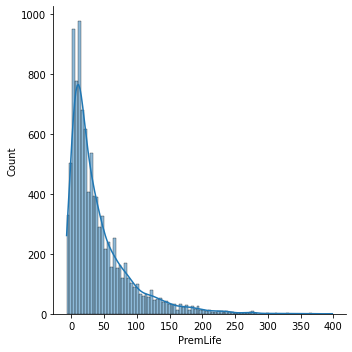

In [135]:
# Checking the histogram of the variable 'PremLife'

sns.displot(data=ds, x="PremLife", kde=True)
plt.show()

Right skewed distribution, but does not seem to contain outliers.

### The variable 'PremWork':

In [136]:
ds['PremWork'].unique()

array([ 1.6890e+01,  1.0613e+02,  9.9020e+01,  2.8340e+01,  4.1450e+01,
        7.6700e+00,  2.6340e+01,  5.3230e+01,  9.8900e+00,  5.5120e+01,
        1.0890e+01,  3.5450e+01,  1.5780e+01,  9.4460e+01,  1.9670e+01,
        3.7230e+01,  2.7560e+01,  7.2570e+01,  3.0560e+01,  3.3340e+01,
        5.4900e+01,  3.3560e+01,  4.7800e+00,  2.2780e+01,  9.7800e+00,
       -1.1000e-01, -5.0000e+00, -5.1100e+00,  9.6700e+00,  7.8900e+00,
        7.2680e+01,  6.5790e+01,  8.4350e+01,  4.0230e+01,  5.7800e+00,
        1.4803e+02,  2.5340e+01,  2.5560e+01,  2.3340e+01,  4.4230e+01,
        7.5790e+01,  6.9900e+01,  1.4890e+01,  3.8900e+00, -9.0000e+00,
        3.0450e+01,  2.7800e+00,  1.0000e+01,  6.2680e+01,  1.6780e+01,
        5.1120e+01,  8.7800e+00,  4.8120e+01, -4.1100e+00, -6.1100e+00,
        9.7350e+01,  1.7890e+01,  7.9680e+01,  3.3230e+01,  5.9900e+01,
        2.0780e+01,  8.9000e-01,  2.9670e+01,  7.3680e+01,  5.0010e+01,
       -3.1100e+00,  3.0230e+01,  2.1670e+01,  1.7780e+01,  5.67

In [137]:
ds = ds[~ds['PremWork'].isin([np.nan, 'nan'])]

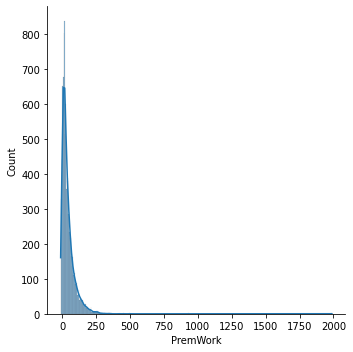

In [138]:
# Checking the histogram of the variable 'PremWork'

sns.displot(data=ds, x="PremWork", kde=True)
plt.show()

Right skewed distribution.

### Checking for missing values:

In [139]:
ds.isna().sum()

FirstPolYear     0
BirthYear        0
EducDeg          0
MonthSal         0
GeoLivArea       0
Children         0
CustMonVal       0
ClaimsRate       0
PremMotor        0
PremHousehold    0
PremHealth       0
PremLife         0
PremWork         0
dtype: int64

We now have no missing data left.

In [157]:
subPlots_Title_fontSize = 12
subPlots_xAxis_fontSize = 10
subPlots_yAxis_fontSize = 10
subPlots_label_fontSize = 10
heatmaps_text_fontSize = 8

plots_Title_fontSize = 14
plots_Title_textColour = 'black'

plots_Legend_fontSize = 12
plots_Legend_textColour = 'black'

plots_barTexts_fontSize = 8

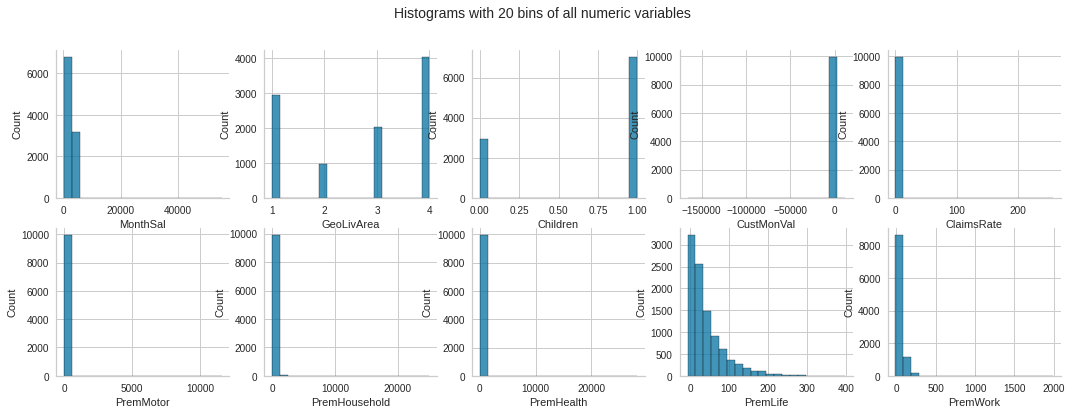

In [158]:
# HISTOGRAM (ALL NUMERIC VARIABLES)

# Identify all numeric variables in the dataset
numerical=ds.select_dtypes(include=[np.number]).columns.tolist()

# Draw
fig, ax = plt.subplots(2, 5, figsize=(18,6))
for var, subplot in zip(ds[numerical], ax.flatten()):
    g = sns.histplot(data=ds,
                bins=20,
                 x=var,
                 ax=subplot,
                 kde=False)

# Decoration
sns.despine()
plt.rc('axes', labelsize=subPlots_label_fontSize)
fig.suptitle("Histograms with 20 bins of all numeric variables", fontsize=plots_Title_fontSize);

# Features Engineering:

### Converting 'BirthYear' into 'Age':

We convert the variable 'BirthYear' into 'Age'.

In [140]:
ds['Age'] = 2016 - ds['BirthYear']

In [141]:
ds.drop(columns=['BirthYear'], inplace=True)

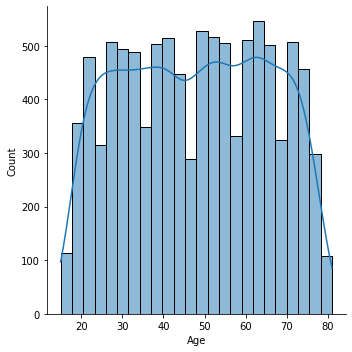

In [144]:
# Checking the histogram of the variable 'Age'.

sns.displot(data=ds, x="Age", kde=True)
plt.show()

### Converting the variable 'FirstPolYear' into 'YearsAsCustomer':

We convert the variable 'FirstPolYear' into 'YearsAsCustumer'

In [142]:
ds['YearsAsCustumer'] = 2016 - ds['FirstPolYear']

In [143]:
ds.drop(columns=['FirstPolYear'], inplace=True)

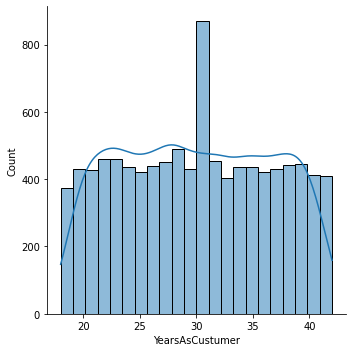

In [145]:
# Checking the histogram of the variable 'YearsAsCustumer'.

sns.displot(data=ds, x="YearsAsCustumer", kde=True)
plt.show()

# Data Prepararion:

In [146]:
X = ds.copy(deep=True)

## Encoding categorical variables:

In [155]:
# Encode categorical variables to dummy variables
# For more information the different methods to enconde categorical variables check https://contrib.scikit-learn.org/category_encoders/
cols = ['EducDeg', 'GeoLivArea', 'Children']
ce_one_hot = ce.OneHotEncoder(cols = cols, use_cat_names=True)
X = ce_one_hot.fit_transform(X)

## Scaling the numerical variables:

In [159]:
# Get a copy of the dataframe before normalization for results' analysis
X_beforeNorm = X.copy(deep=True)

In [160]:
# Normalize all columns
# MinMax scaler returns an array, so the dataframe must be recreated
X = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(X.values), columns=X.columns,index=X.index)

In [161]:
# Check dataframe structure and statistics after all transformations
print(X.shape)
X.describe(include='all').T

(9985, 20)


,count,mean,std,min,25%,50%,75%,max
EducDeg_'2 - High School',9985.0,0.343415,0.474872,0.0,0.000000,0.000000,1.000000,1.0
EducDeg_'1 - Basic',9985.0,0.124687,0.330380,0.0,0.000000,0.000000,0.000000,1.0
EducDeg_'3 - BSc/MSc',9985.0,0.464997,0.498798,0.0,0.000000,0.000000,1.000000,1.0
EducDeg_'4 - PhD',9985.0,0.066900,0.249862,0.0,0.000000,0.000000,0.000000,1.0
MonthSal,9985.0,0.039588,0.021213,0.0,0.024908,0.039485,0.053934,1.0
GeoLivArea_1.0,9985.0,0.295844,0.456444,0.0,0.000000,0.000000,1.000000,1.0
GeoLivArea_4.0,9985.0,0.404206,0.490762,0.0,0.000000,0.000000,1.000000,1.0
GeoLivArea_3.0,9985.0,0.201703,0.401291,0.0,0.000000,0.000000,0.000000,1.0
GeoLivArea_2.0,9985.0,0.098247,0.297664,0.0,0.000000,0.000000,0.000000,1.0
Children_1.0,9985.0,0.705658,0.455769,0.0,0.000000,1.000000,1.000000,1.0


- The results transformation made the modeling dataset end up with 20 columns.
- All columns are now numeric, with values in the range of 0 to 1

## Analyze Principal Components:

(9985, 2)


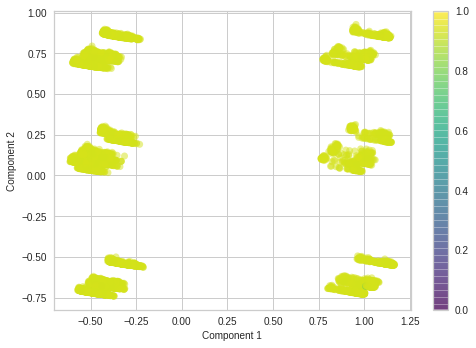

In [163]:
# Let's use PCA to visualize with only two components
pca2 = PCA(n_components = 2)
pca2.fit(X)
X_pca2 = pca2.transform(X)
print(X_pca2.shape)

# Scatter plot of the two Principal Components by the "target" to see if there is any pattern
plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=X.CustMonVal, edgecolor='none', alpha=0.5, cmap='viridis')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar();

In [164]:
# Fit the PCA algorithm to data 
pca = PCA().fit(X)

# Show the variance per component
pcaevr = ['{:f}'.format(item) for item in pca.explained_variance_ratio_]
pcaDF = pd.DataFrame({'Component': range(1, len(X.columns)+1),
                      'Variance explained': pcaevr,
                      'Cumulative variance explained': np.cumsum(pca.explained_variance_ratio_)})
pcaDF

,Component,Variance explained,Cumulative variance explained
0,1,0.226874,0.226874
1,2,0.208464,0.435337
2,3,0.180555,0.615892
3,4,0.121445,0.737337
4,5,0.089724,0.827061
5,6,0.060586,0.887646
6,7,0.042979,0.930625
7,8,0.039388,0.970014
8,9,0.024209,0.994223
9,10,0.005000,0.999223


- From the above we can see that two components only explain 43% of the variance, meaning its not enough to select the number of clusters using the plot above.

## Kmeans:

In [165]:
# Apply the dimension reduction to the dataset (for 8 components)
pca_reduced = PCA(n_components = 8)
pca_reduced.fit(X)
X_pca_reduced = pca_reduced.transform(X) 
print(X_pca_reduced.shape)

(9985, 8)


In [184]:
X_pca_reduced

array([[-0.54310822,  0.68465459,  0.74217284, ..., -0.10893153,
        -0.0777528 , -0.04780858],
       [-0.42040061,  0.88923184, -0.62310196, ..., -0.0784025 ,
        -0.14915068, -0.22224871],
       [ 0.91573733,  0.12977991,  0.38636208, ..., -0.21751775,
        -0.28597846,  0.19018054],
       ...,
       [-0.49998751, -0.71726692,  0.56139351, ..., -0.09124533,
        -0.07374463,  0.33128368],
       [-0.4590743 ,  0.1474522 ,  0.11921352, ...,  1.02423007,
        -0.21158493, -0.2358135 ],
       [-0.53078206,  0.03835355,  0.66862657, ..., -0.08903541,
         0.97694764,  0.22681809]])

In [182]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
EducDeg_'2 - High School',9985.0,0.343415,0.474872,0.0,0.000000,0.000000,1.000000,1.0
EducDeg_'1 - Basic',9985.0,0.124687,0.330380,0.0,0.000000,0.000000,0.000000,1.0
EducDeg_'3 - BSc/MSc',9985.0,0.464997,0.498798,0.0,0.000000,0.000000,1.000000,1.0
EducDeg_'4 - PhD',9985.0,0.066900,0.249862,0.0,0.000000,0.000000,0.000000,1.0
MonthSal,9985.0,0.039588,0.021213,0.0,0.024908,0.039485,0.053934,1.0
GeoLivArea_1.0,9985.0,0.295844,0.456444,0.0,0.000000,0.000000,1.000000,1.0
GeoLivArea_4.0,9985.0,0.404206,0.490762,0.0,0.000000,0.000000,1.000000,1.0
GeoLivArea_3.0,9985.0,0.201703,0.401291,0.0,0.000000,0.000000,0.000000,1.0
GeoLivArea_2.0,9985.0,0.098247,0.297664,0.0,0.000000,0.000000,0.000000,1.0
Children_1.0,9985.0,0.705658,0.455769,0.0,0.000000,1.000000,1.000000,1.0


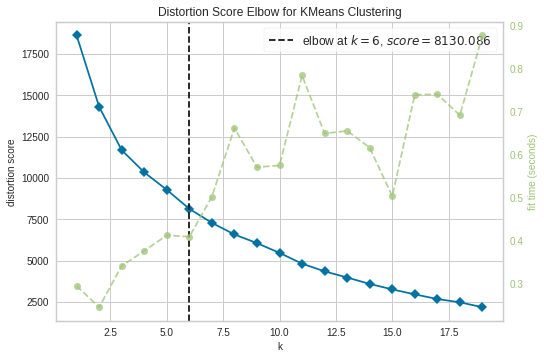

In [166]:
# Apply the Elbow method to select K
km = KMeans()
visualizer = KElbowVisualizer(km, k=(1,20), random_state=123)
visualizer.fit(X_pca_reduced)
visualizer.show() 

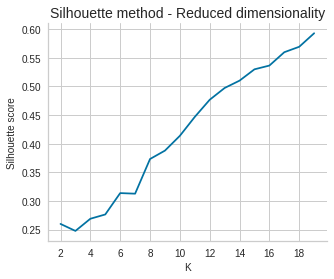

In [167]:
# Select K based on the Silhouette method
# ATTENTION! Depending on the computer this can take long time to run (more than 10 minutes)
sil = []

# Dissimilarity can only be measured in more than 1 partition, therefore it starts on K=2
for k in range(2, 20):
  km = KMeans(n_clusters = k, random_state=123).fit(X)
  labels = km.labels_
  sil.append(silhouette_score(X, labels, metric = 'euclidean'))


# Show Results
# Draw
fig , ax = plt.subplots(figsize=(5, 4))
plt.plot(range(2, 20), sil, 'bx-')
# Decoration
sns.despine()
fmt = "{x:,.2f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
plt.xlabel('K')
plt.ylabel('Silhouette score')
plt.rc('axes', labelsize=subPlots_label_fontSize)
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.title('Silhouette method - Reduced dimensionality', fontsize=plots_Title_fontSize);

The silhouette method does not allow us to conclude about the method to use, we select a number of clusters equal to 6.

In [168]:
# Apply the K-Means for K=6
K=6
kmeans = KMeans(n_clusters=K, random_state=2022)
allDistances = kmeans.fit_transform(X_pca_reduced)
y_kmeans = kmeans.predict(X_pca_reduced)

In [180]:
y_kmeans

array([1, 2, 4, ..., 1, 3, 1], dtype=int32)

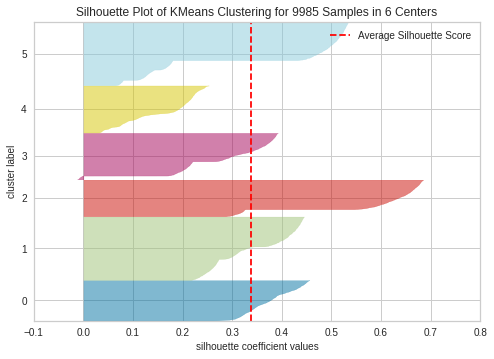

In [169]:
# Visualize Silhouette - see https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X_pca_reduced)
visualizer.show()

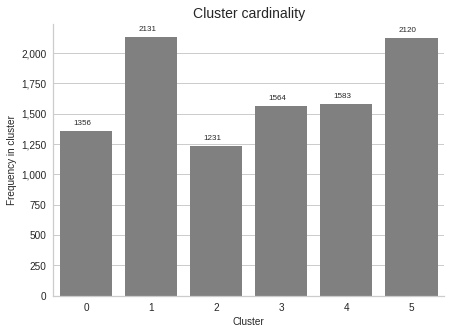

In [170]:
# Plot clusters cardinality 

# Count observations per cluster
freqByCluster = X_beforeNorm.groupby(y_kmeans).size()

# Draw
fig, ax = plt.subplots(figsize=(7,5))
g = sns.countplot(x=y_kmeans, color='grey')

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
for index,data in enumerate(freqByCluster):
    plt.text(x=index-0.2 , y=data+50 , s=f"{data}" , fontdict=dict(fontsize=plots_barTexts_fontSize))
sns.despine()
plt.title("Cluster cardinality", fontsize=plots_Title_fontSize)
plt.xlabel("Cluster")
plt.ylabel("Frequency in cluster")
plt.rc('axes', labelsize=subPlots_label_fontSize)

- We can see that the clusters 3 and 4 have the same cardinality, maybe we can merge them.
- The cluster 1 and 5 have similar cardinality, same thing apply for the cluster 0 and 2.


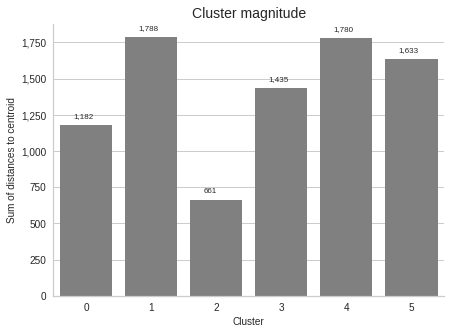

In [171]:
# Plot clusters magnitude

# Compute Magnitude
X['distanceToCentroid'] = np.min(allDistances,axis=1)
magnitude = X['distanceToCentroid'].groupby(y_kmeans).sum()
X = X.drop(columns=['distanceToCentroid'])

# Draw
fig, ax = plt.subplots(figsize=(7,5))
g = sns.barplot(x=magnitude.index, y=magnitude.values, color='grey')

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
for index,data in enumerate(magnitude):
    plt.text(x=index-0.2 , y=data+50 , s=f"{data:,.0f}" , fontdict=dict(fontsize=plots_barTexts_fontSize))
sns.despine()
plt.title("Cluster magnitude", fontsize=plots_Title_fontSize)
plt.xlabel("Cluster")
plt.ylabel("Sum of distances to centroid")
plt.rc('axes', labelsize=subPlots_label_fontSize)

- The cluster 2 has the smallest sum of distances to centroid.
- We should investigate more the clusters 1 and 4.

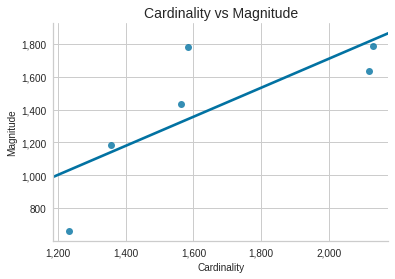

In [172]:
# Plot cardinality vs magnitude

# Draw
fig, ax = plt.subplots(figsize=(6,4))
g = sns.regplot(x=freqByCluster, y=magnitude, scatter=True, seed=123,truncate=False, ci=None)

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick)
ax.yaxis.set_major_formatter(tick)
sns.despine()
plt.title("Cardinality vs Magnitude", fontsize=plots_Title_fontSize)
plt.xlabel("Cardinality")
plt.ylabel("Magnitude")
plt.rc('axes', labelsize=subPlots_label_fontSize)

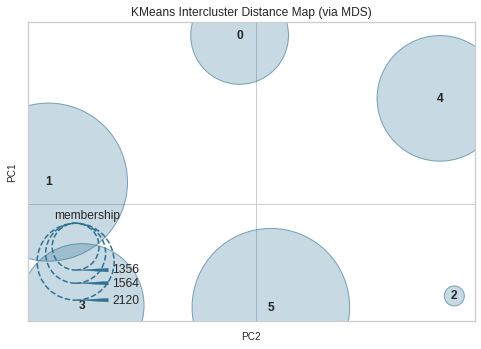

In [173]:
# Visualizing the clusters sizes and distances in 2D
visualizer = InterclusterDistance(kmeans)
visualizer.fit(X_pca_reduced)
visualizer.show()

- We can see an intersection between the clusters 1 and 3, we need to find a way to solve this issue.

In [174]:
# Create a dataframe with the weights per component
wheightsDF = pd.DataFrame(pca.components_,columns=X.columns)
wheightsDF

,EducDeg_'2 - High School',EducDeg_'1 - Basic',EducDeg_'3 - BSc/MSc',EducDeg_'4 - PhD',MonthSal,GeoLivArea_1.0,GeoLivArea_4.0,GeoLivArea_3.0,GeoLivArea_2.0,Children_1.0,Children_0.0,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,Age,YearsAsCustumer
0,-0.005833,-0.012654,0.015529,0.002958,1.425409e-02,-0.072625,0.089756,-0.019027,1.895368e-03,-0.684180,0.684180,-6.154061e-06,4.303346e-05,-3.544943e-03,8.734127e-04,9.568554e-04,1.479869e-02,2.143161e-03,2.217274e-01,-7.152965e-03
1,0.660643,0.053623,-0.733931,0.019666,-2.127466e-03,-0.072495,0.105833,-0.031145,-2.192885e-03,-0.006073,0.006073,2.384292e-04,-1.506611e-04,-5.753065e-03,3.820741e-03,4.300977e-04,5.000143e-02,9.359472e-03,-3.858056e-02,-1.295574e-03
2,0.083716,0.005409,-0.099170,0.010046,1.061737e-03,0.589177,-0.774493,0.142251,4.306552e-02,-0.082243,0.082243,1.379221e-04,-1.311066e-04,-1.156927e-03,4.300877e-04,2.864336e-04,7.011359e-03,1.871602e-03,1.944980e-02,-2.482634e-03
3,0.012848,-0.001998,-0.006704,-0.004145,2.143774e-05,-0.568813,-0.285131,0.766301,8.764371e-02,0.001431,-0.001431,-3.320705e-05,1.145592e-04,8.833114e-04,-9.758248e-05,4.486944e-04,-1.182204e-03,8.674611e-04,3.800657e-03,4.507552e-04
4,-0.505164,0.737060,-0.381441,0.149545,-9.928695e-03,-0.004732,0.002556,0.006839,-4.662821e-03,-0.032247,0.032247,4.725812e-04,-1.888473e-04,-8.161193e-03,6.454228e-03,-4.712761e-04,8.742052e-02,1.676778e-02,-1.528797e-01,3.248645e-03
5,-0.008867,0.004968,-0.001655,0.005554,1.223335e-03,-0.262011,-0.222476,-0.375566,8.600531e-01,0.008554,-0.008554,1.839336e-04,-2.239909e-04,6.483139e-05,-2.090413e-04,-3.003419e-04,-4.914011e-03,-1.025564e-03,1.707434e-02,-2.262062e-02
6,-0.224514,-0.374811,-0.227781,0.827107,1.373436e-02,-0.003591,0.006665,0.004488,-7.561446e-03,0.038059,-0.038059,-1.158082e-04,-2.604038e-04,1.455298e-02,-9.363390e-03,-1.067761e-03,-1.297139e-01,-2.315063e-02,2.194104e-01,6.400240e-02
7,-0.016937,-0.015868,-0.015837,0.048643,3.056596e-03,0.004836,0.006583,0.009100,-2.051870e-02,0.011378,-0.011378,-1.625575e-04,1.648106e-04,1.006198e-03,-1.352259e-03,3.442266e-05,-6.830756e-03,-2.952232e-04,3.731224e-02,-9.972781e-01
8,0.001342,0.234659,-0.047646,-0.188355,5.751783e-02,0.009156,0.003317,0.003726,-1.619881e-02,0.144189,-0.144189,1.478170e-04,-5.007391e-04,1.638991e-02,-8.073138e-03,-2.091273e-03,-1.340887e-01,-2.034904e-02,9.178582e-01,2.700539e-02
9,-0.019125,-0.087072,0.035636,0.070561,1.234687e-02,-0.000199,-0.001517,0.000467,1.249058e-03,0.039557,-0.039557,1.325831e-04,1.091393e-04,-3.926555e-02,1.113129e-02,7.624445e-05,9.755150e-01,2.423487e-02,1.691432e-01,5.078826e-03


In [177]:
# Study the weights of component 15
comp = abs(wheightsDF.iloc[0])  ## index 14 is component 15
comp = comp.sort_values(ascending=False)
comp

Children_0.0                 0.684180
Children_1.0                 0.684180
Age                          0.221727
GeoLivArea_4.0               0.089756
GeoLivArea_1.0               0.072625
GeoLivArea_3.0               0.019027
EducDeg_'3 - BSc/MSc'        0.015529
PremLife                     0.014799
MonthSal                     0.014254
EducDeg_'1 - Basic'          0.012654
YearsAsCustumer              0.007153
EducDeg_'2 - High School'    0.005833
PremMotor                    0.003545
EducDeg_'4 - PhD'            0.002958
PremWork                     0.002143
GeoLivArea_2.0               0.001895
PremHealth                   0.000957
PremHousehold                0.000873
ClaimsRate                   0.000043
CustMonVal                   0.000006
Name: 0, dtype: float64

Wtf does this plot shows, does it even matter.

In [185]:
# Check the mean values of each cluster for top 30 relevant features
top_features = comp[:30].index
clustersMeanDF = pd.DataFrame(X[top_features].groupby(y_kmeans).mean(),columns=top_features)
clustersMeanDF.transpose()

,0,1,2,3,4,5
Children_0.0,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
Children_1.0,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
Age,0.745195,0.408238,0.415688,0.416734,0.657430,0.419919
GeoLivArea_4.0,0.414454,0.000000,0.806661,0.000000,0.428301,0.850472
GeoLivArea_1.0,0.286136,1.000000,0.000000,0.000000,0.274795,0.000000
GeoLivArea_3.0,0.201327,0.000000,0.000000,0.918798,0.192040,0.000000
EducDeg_'3 - BSc/MSc',1.000000,0.471140,0.000000,0.439898,0.000000,0.752358
PremLife,0.100768,0.113880,0.132325,0.112602,0.177112,0.098493
MonthSal,0.055296,0.033727,0.035095,0.034012,0.049997,0.034383
EducDeg_'1 - Basic',0.000000,0.127640,0.000000,0.163683,0.233102,0.164151


- We obviously needs to bin the numerical variables in order to be able to comment the obtained clusters. 